In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
import sqlite3
from scipy.optimize import curve_fit
from matplotlib.backends import backend_pdf

In [2]:
def getRun(run, path="/exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb"):
    
    files = [ f for f in os.listdir(path) if str(run) in f ]
    timestamp = files[0].split("_")[0]
    
    # load the files as a dataframe
    file = path + "/" + files[0]
    df = pd.read_csv(file, sep=",")
    
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")

    print("Reading " + file + " ...")
    
    return df

In [3]:
# SUPPORT FUNCTIONS TO CONVERT CHANNEL ID TO BOARD/PMT ID
# using hardware database inside icarus_data

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_79_01/icarus_data/database/ChannelMapICARUS_20230829.db", 
                 table="pmt_placements_29aug2023"):
    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)
    con.close()
    return df

def getDigitizer(db, channel):
    _SELCH = (db.channel_id==channel)
    return db[_SELCH].digitizer_label.values[0], db[_SELCH].digitizer_ch_number.values[0]

def getChannelID(db, board, digitizer_channel):
    _SELDB = (db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel)
    ch = db[_SELDB].channel_id.values[0]
    return ch

def computeChannel(row, db): 
    if row["digitizer_channel"] == 15: 
        return 1000
    return getChannelID(db, row["board"],row["digitizer_channel"])

In [4]:
def getConfig(file, path="/exp/icarus/data/users/mvicenzi/pmt-baselines/configdb"):
        
    # load the files as a dataframe
    f = path + "/" + file
    df = pd.read_csv(f, sep=",")
    geodb = readSqlitedb()
    
    # add column converting board + digitizer_channel into channel id
    df["ch"] = df.apply(computeChannel, axis=1, args=(geodb,)) 

    print("Reading " + f + " ...")
    
    return df

In [5]:
# load data from all files for calibrations
def loadfiles(runs):

    data = {}
    for label, run in runs.items():
        
        dfmeas = getRun(run)
        dfconf = getConfig(label)
        df_merged = pd.merge(dfmeas, dfconf, on='ch')
        
        lab = label.split("_")[-1].rstrip(".csv")
        data[lab] = df_merged
        
    return data

In [6]:
def getChannelData(ch, data, n=500, minerr=1.0):
    
    bs = []
    err = []
    offsets = []
    
    for label, df in data.items():
        
        _SELCH = (df.ch==ch)
        
        baselines = df[_SELCH].baseline.head(n).to_numpy()
        pedestals = df[_SELCH].pedestal.head(n).to_numpy()
        
        bs.append(np.median(baselines))
        rms = np.sqrt( np.square(np.subtract(baselines,np.median(baselines))).mean())
        if rms < minerr: rms = minerr
        err.append(rms)
        
        offsets.append(pedestals[0])

    return offsets, bs, err

In [7]:
def line(x,a,b):
    return a*x+b

def extrapolateLine(bs_target, a, err_a, b, err_b):
    
    dacnom = (bs_target-b)/a
    
    dxdb = -1./a
    dxda = (b-bs_target)/(a**2)
    
    edacnom = np.sqrt( (dxdb*err_b)**2 + (dxda*err_a)**2 )
    
    return dacnom, edacnom

In [8]:
def doFit( dcoffset, baseline, error_baseline, bs_target = 14747):
    
    a0 = (baseline[1]-baseline[0])/(dcoffset[1]-dcoffset[0])
    b0 = baseline[0]
    
    params, pcov = curve_fit(line, dcoffset, baseline, sigma=error_baseline, absolute_sigma=True, p0=(a0,b0))
            
    stderr = np.sqrt(np.diag(pcov))
    
    xint = np.linspace( np.min(dcoffset)-10, np.max(dcoffset)+10, 1000 )
    yint = line(xint, params[0], params[1])
    
    dacnom, edacnom= extrapolateLine( bs_target, params[0], stderr[0] , params[1], stderr[1] )
    
    return params, stderr, xint, yint, dacnom, edacnom

# Baseline calibration

In [9]:
runs = {  "20240813_equalization_nom.csv": 12256,
          "20240813_equalization_m5.csv" : 12257,
          "20240813_equalization_m10.csv": 12258,
          "20240813_equalization_m20.csv": 12259,
          "20240813_equalization_p5.csv" : 12260,
          "20240813_equalization_p10.csv": 12261,
          "20240813_equalization_p20.csv": 12262,
       }

today="20240813"
data = loadfiles(runs)

Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1723594514_measChannelBaselines_run12256.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/configdb/20240813_equalization_nom.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1723595131_measChannelBaselines_run12257.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/configdb/20240813_equalization_m5.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1723595508_measChannelBaselines_run12258.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/configdb/20240813_equalization_m10.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1723595940_measChannelBaselines_run12259.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/configdb/20240813_equalization_m20.csv ...
Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1723596552_measChannelBaselines_run12260.csv ...
Reading /exp/icarus/data/users/mvicenz

### Plot one channel

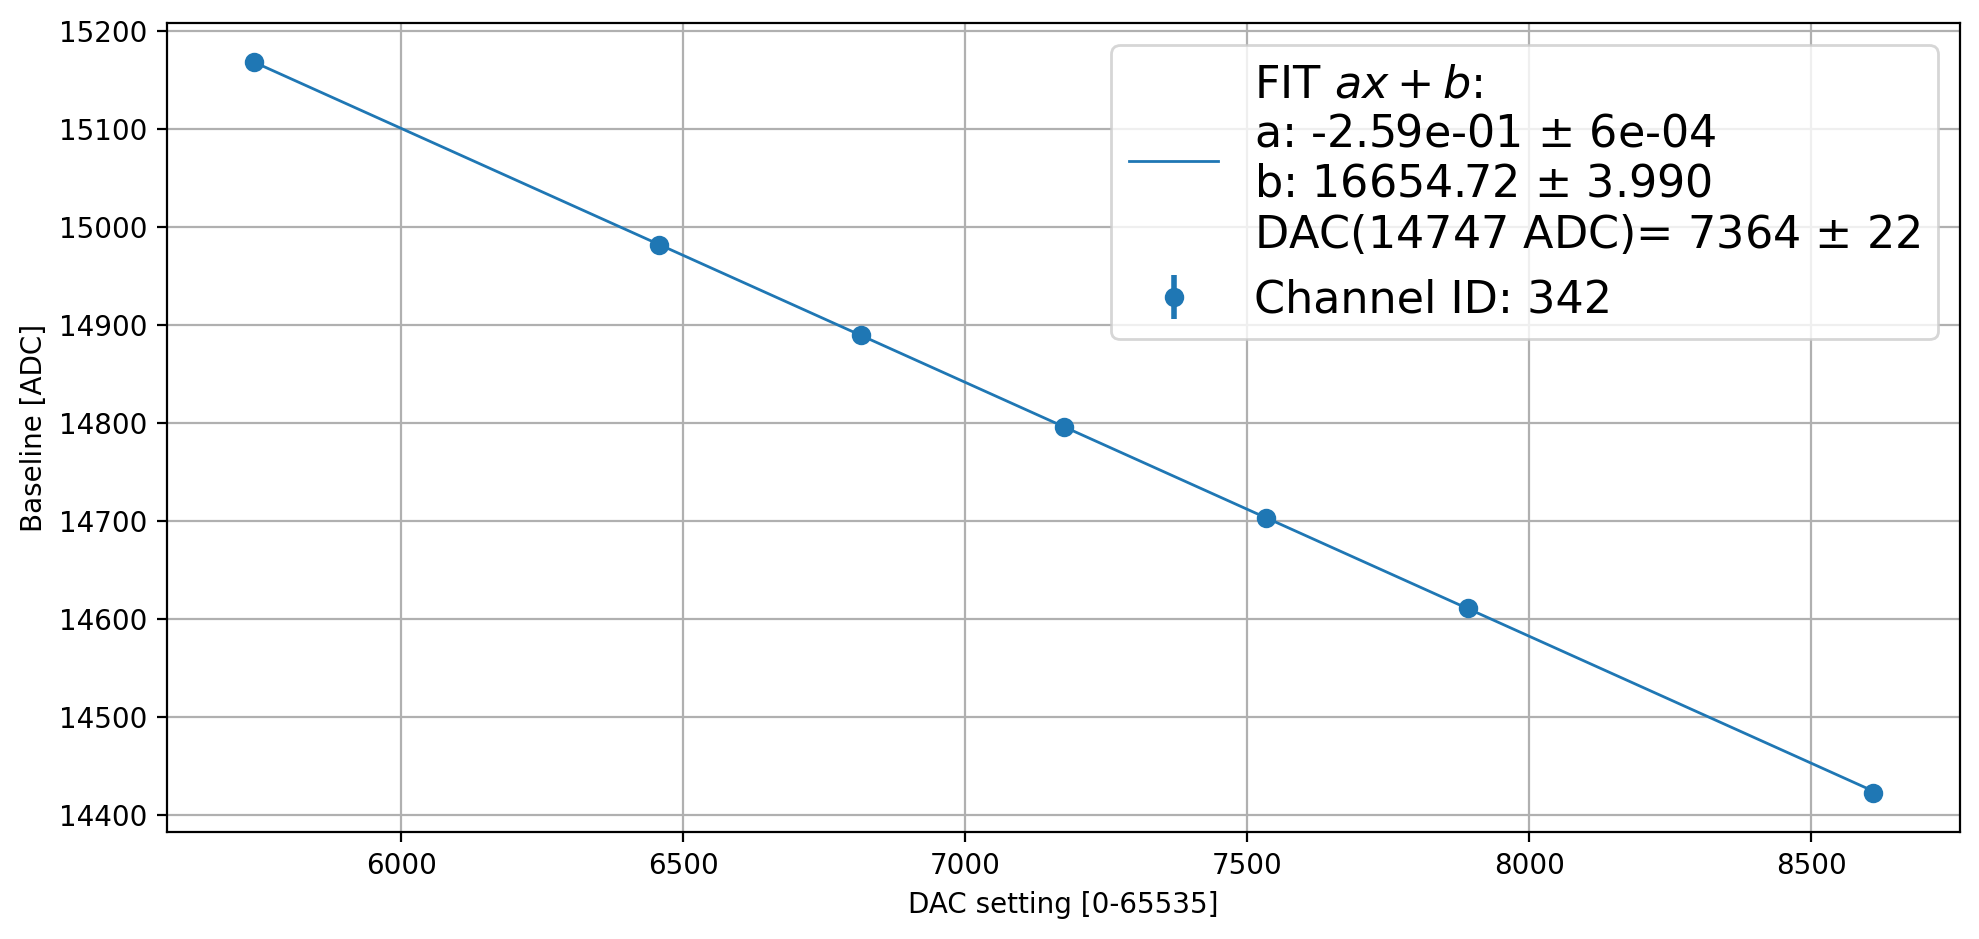

In [10]:
channel_id = 342
dac, bs, err = getChannelData(channel_id, data)
target = 14747

fig, ax = plt.subplots(1,1, figsize=(10, 4.8),dpi=200)
kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}
    
out=plt.errorbar( x=dac, y=bs, yerr=err, label=("Channel ID: %d" % channel_id), **kargs)
p, ep, xint, yint, dacnom, edacnom = doFit(dac, bs, err, bs_target=target)
            
label= "FIT $ax + b$: \n"
label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
plt.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
plt.xlabel("DAC setting [0-65535]")
plt.ylabel("Baseline [ADC]")
plt.legend(fontsize=16)
plt.grid()
    
fig.tight_layout()

### Plot everything

In [11]:
path = "/exp/icarus/data/users/mvicenzi/pmt-baselines/calibrationsdb/"

pdf = backend_pdf.PdfPages(today+"_baseline_calibration.pdf")
target = 14747

calibration = []
DAC_nominal = []

for channel_id in range(0, 360):
            
    # Define the plot
    fig, ax = plt.subplots(1,1, figsize=(10, 4.8), dpi=200)
    kargs={'marker':'o', 'lw':0.0, 'elinewidth':2.0}

    #Fetch data
    dac, bs, ebs = getChannelData(channel_id, data)       
    
    out=ax.errorbar( x=dac, y=bs, yerr=ebs, label=("Channel ID: %d" % channel_id), **kargs )
    
    p, ep, xint, yint, dacnom, edacnom = doFit(dac, bs, ebs, bs_target=target)
   
    calibration.append( {"channel_id": channel_id, 
                    "p0": p[0], 
                    "ep0": ep[0], 
                    "p1": p[1], 
                    "ep1": ep[1], 
                   })
    
    DAC_nominal.append(dacnom)

    label= "FIT $ax + b$: \n"
    label+="a: %.2e $\pm$ %3.e\n" % ( p[0], ep[0] ) 
    label+="b: %.2f $\pm$ %.3f\n" % ( p[1], ep[1] )
    label+='DAC(%d ADC)= %d $\pm$ %d' % ( target, dacnom, edacnom )
            
    ax.plot(xint, yint, color=out[0].get_color(), lw=1.0, label=label)
    
    ax.set_xlabel("DAC setting [0-65535]")
    ax.set_ylabel("Baseline [ADC]")
    ax.legend(fontsize=16)
    
    fig.tight_layout()
    plt.grid()
    pdf.savefig( fig )
    
    plt.close()


pdf.close()

In [12]:
calibDB = pd.DataFrame(calibration)
calibDB.to_csv(path+today+"_baseline_calibration.csv",sep=',',index=False)

## Produce output files

In [15]:
threshold = 390

print("Writing 'CALIBRATED' configuration to equalize baselines at "+str(target))
print("with thresholds at "+str(threshold))

path = "/exp/icarus/data/users/mvicenzi/pmt-baselines/configdb/"
file = path+today+"_equalization_calibrated.csv"

ofile = open(file,"w")
header = "board,digitizer_channel,pedestal,target_baseline,threshold\n"
ofile.write(header)

geodb = readSqlitedb()   

for channel in range(0,360):
    
    dig, dig_ch = getDigitizer(geodb, channel)
    thres = target - threshold
    
    out = str(dig) + "," + str(dig_ch) + ","
    out += str(int(DAC_nominal[channel]))+","
    out += str(target) + "," + str(thres) + "\n"
    
    ofile.write(out)
    
# add info on spare channels
digitizers = np.unique(geodb.digitizer_label.to_numpy())
for d in digitizers:
    
    out = str(d) + ",15,7537,14500,100\n"
    ofile.write(out)
    
ofile.close()

Writing 'CALIBRATED' configuration to equalize baselines at 14747
with thresholds at 390
